# Toy Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.costs import RevGaussCost
from loss_cal.utils.utils import load_data, atleast_2d_col
from loss_cal.bam import train, build_nn
from loss_cal.actions import Action
from sbi.utils.torchutils import atleast_2d
from sbi.utils.sbiutils import gradient_ascent
from functools import partial


plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = '#377eb8'
color_nn = '#ff7f00'
color_post = '#4daf4a'
seed = 0 #84 #2023

torch.manual_seed(seed)

## Set Up

In [3]:
toy = ToyExample(action_type="continuous")
toy.task_name

'toy_example'

Prior and Simulator

In [4]:
prior = toy.get_prior()
simulator = toy.get_simulator()

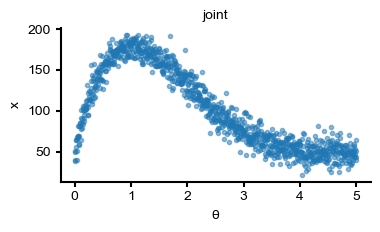

In [5]:
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1,1, figsize=(4,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Posterior

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/toy_example.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean).to(self.device),


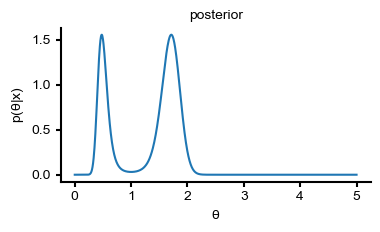

In [6]:
resolution = 1000
x = 150
posterior_evals = toy.gt_posterior(torch.Tensor([x]))
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    thetas = torch.linspace(toy.param_low.item(), toy.param_high.item(), resolution)
    ax.plot(thetas, posterior_evals)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Continuous Actions

### Decision Task

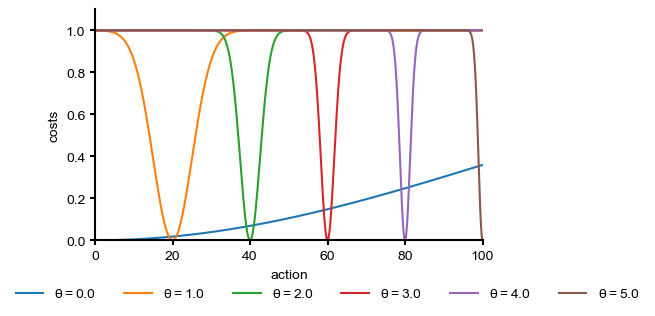

In [7]:
# loss = SquaredLoss(factor=1)
factor = 1.5
exponential = 2
cost_fn = RevGaussCost(parameter_range=[toy.param_low, toy.param_high], action_range=[toy.action_low, toy.action_high], factor=factor, exponential=exponential)

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(toy.action_low, toy.action_high, (toy.action_high - toy.action_low) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for theta in torch.arange(toy.param_low.item(), toy.param_high.item()+0.01, 1):
        ax.plot(actions, cost_fn(theta, actions), label=rf"$\theta={theta}$")

    ax.set_xlabel(r"$action$")
    ax.set_ylabel("costs")
    ax.set_xlim(toy.action_low, toy.action_high)
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

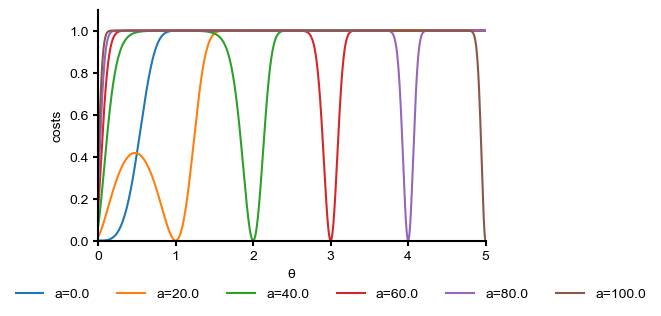

In [8]:
with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    thetas = torch.arange(toy.param_low.item(), toy.param_high.item(), (toy.param_high.item() - toy.param_low.item()) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for a in torch.arange(toy.action_low, toy.action_high+0.01, 20):
        ax.plot(thetas, cost_fn(thetas, a), label=f"a={a}")

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("costs")
    ax.set_xlim(toy.param_low.item(), toy.param_high.item())
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/toy_example.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean).to(self.device),


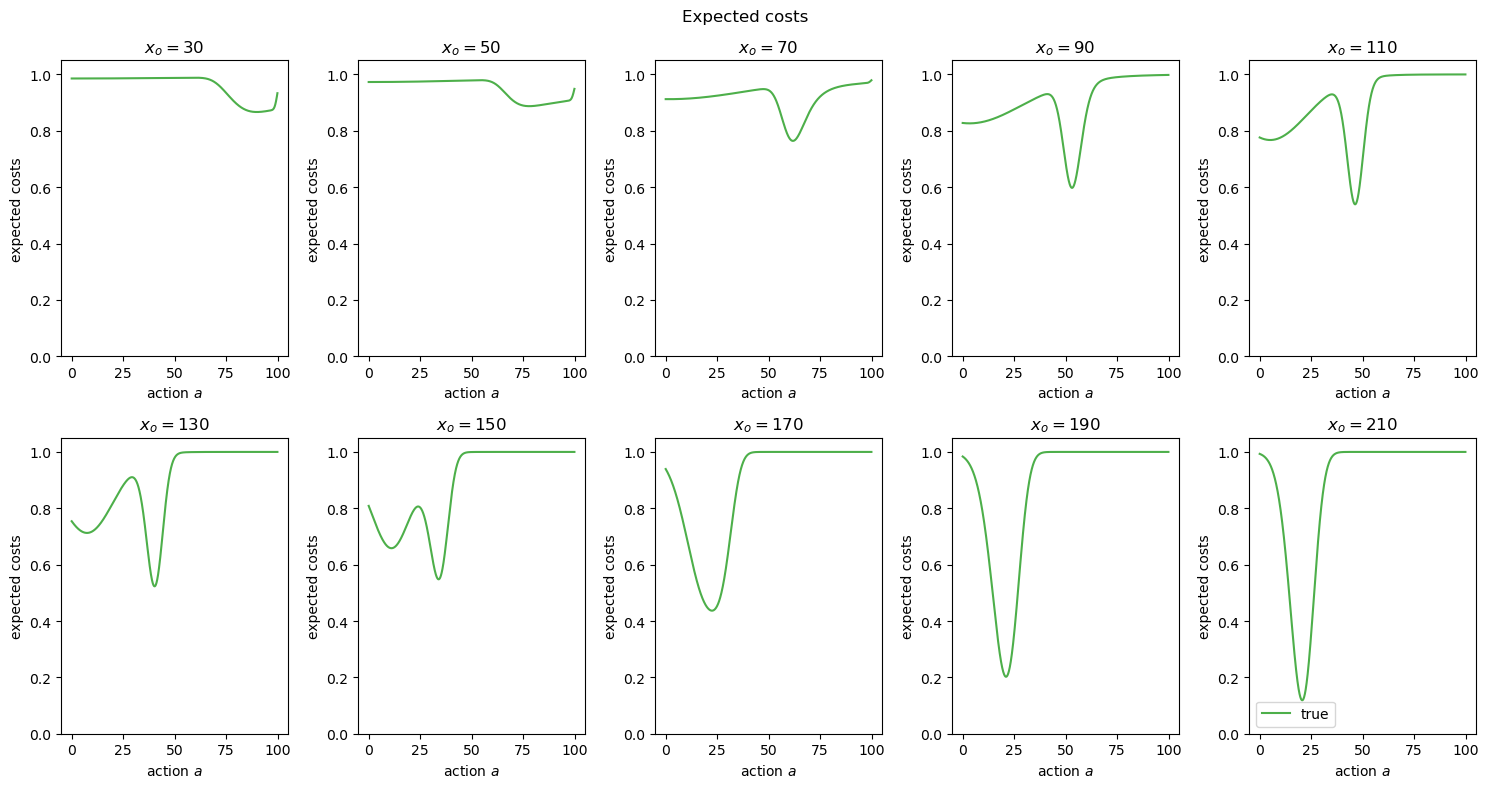

In [9]:
obs = torch.arange(30, 230, 20)
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

plt.figure(figsize=(15, 8))
for i, x in enumerate(obs):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = toy.expected_posterior_costs(
                x=x,
                a=a_grid,
                cost_fn=cost_fn
            )


    plt.plot(a_grid, expected_posterior_costs.squeeze(), c=color_post, label="true")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.ylim(0, 1.05)
    plt.title(rf"$x_o=${x}")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
plt.show()

### Actions

In [10]:
actions = toy.actions

### Load data

In [11]:
n_train = 5_000
n_test = 1_000

(
    theta,
    x,
    theta_test,
    x_test,
) = load_data("toy_example")

# TRAIN-VAL SPLIT (90:10)
validation_fraction = 0.1
# Get total number of training examples.
num_examples = n_train
# Select random train and validation splits from (theta, x) pairs.
num_training_examples = int((1 - validation_fraction) * num_examples)
num_validation_examples = num_examples - num_training_examples
permuted_indices = torch.randperm(num_examples)
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

theta_train = toy.param_aggregation(theta[train_indices])
x_train = x[train_indices]
theta_val = toy.param_aggregation(theta[val_indices])
x_val = x[val_indices]

x_test = x_test[:n_test]
theta_test = toy.param_aggregation(theta_test[:n_test])

actions_evaluate = toy.actions.sample(theta_train.shape[0])

print(f"ntrain = {theta_train.shape[0]}, nval = {theta_val.shape[0]},  ntest = {theta_test.shape[0]}")

Load data from './data/toy_example', device = cpu.
ntrain = 4500, nval = 500,  ntest = 1000


### Train a neural network to predict expected costs

In [12]:
nn = build_nn(
    "fc",
    x_train=x_train,
    action_train=actions_evaluate,
    hidden_dims=[50,50,50],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.Sigmoid(),
    seed=seed
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn= cost_fn, 
    x_val=x_val,
    theta_val=theta_val,
    actions=toy.actions, 
    learning_rate=1e-3,
    model_dir="./results/toy_example/continuous/notebook",
    #max_num_epochs=800,
    stop_after_epochs=50, #50,
    seed=seed, 
    #save_sampled_actions = True,
    num_action_samples_train=1, #previously the network converged after 73 epochs, with one new action per epoch
    num_action_samples_val=10,
    sample_actions_in_loop=True
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Sigmoid()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
313	 val_loss = 0.04326860	 train_loss = 0.04359556	 last_improvement = 50
---------------------------------------------------------------------------------
|	Converged after 313 epochs, best achieved validation loss: 0.0431.	|
---------------------------------------------------------------------------------



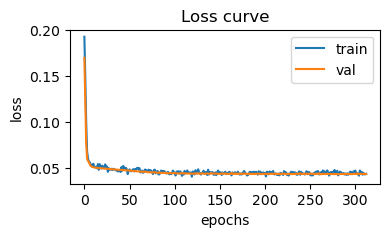

tensor(0.0431)


In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()
print(val_loss.min())

### Evaluate model

#### Check predictions on the training data

In [14]:
predictions_train = nn(x_train, actions_evaluate)
true_expected_costs_train = torch.Tensor(
    [
        toy.expected_posterior_costs(
            x_o, a_o, cost_fn=cost_fn
        )
        for x_o, a_o in zip(x_train, actions_evaluate)
    ]
)

In [15]:
# MSE
print(f"MSE on training data: {((predictions_train.squeeze() - true_expected_costs_train)**2).mean() :.6f}")

MSE on training data: 0.000227


#### Check incurred losses

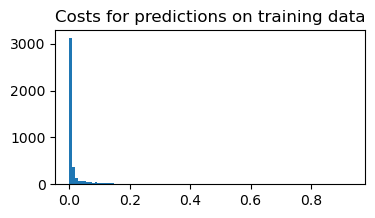

In [16]:
losses_train = torch.mean((cost_fn(theta_train, actions_evaluate) - predictions_train) ** 2, dim=1)
# torch.median(losses_train), torch.mean(losses_train)
plt.figure(figsize=(4, 2))
plt.hist(losses_train.detach().numpy(), bins=100)
plt.title("Costs for predictions on training data")
plt.show()

#### Check true and predicted expected costs

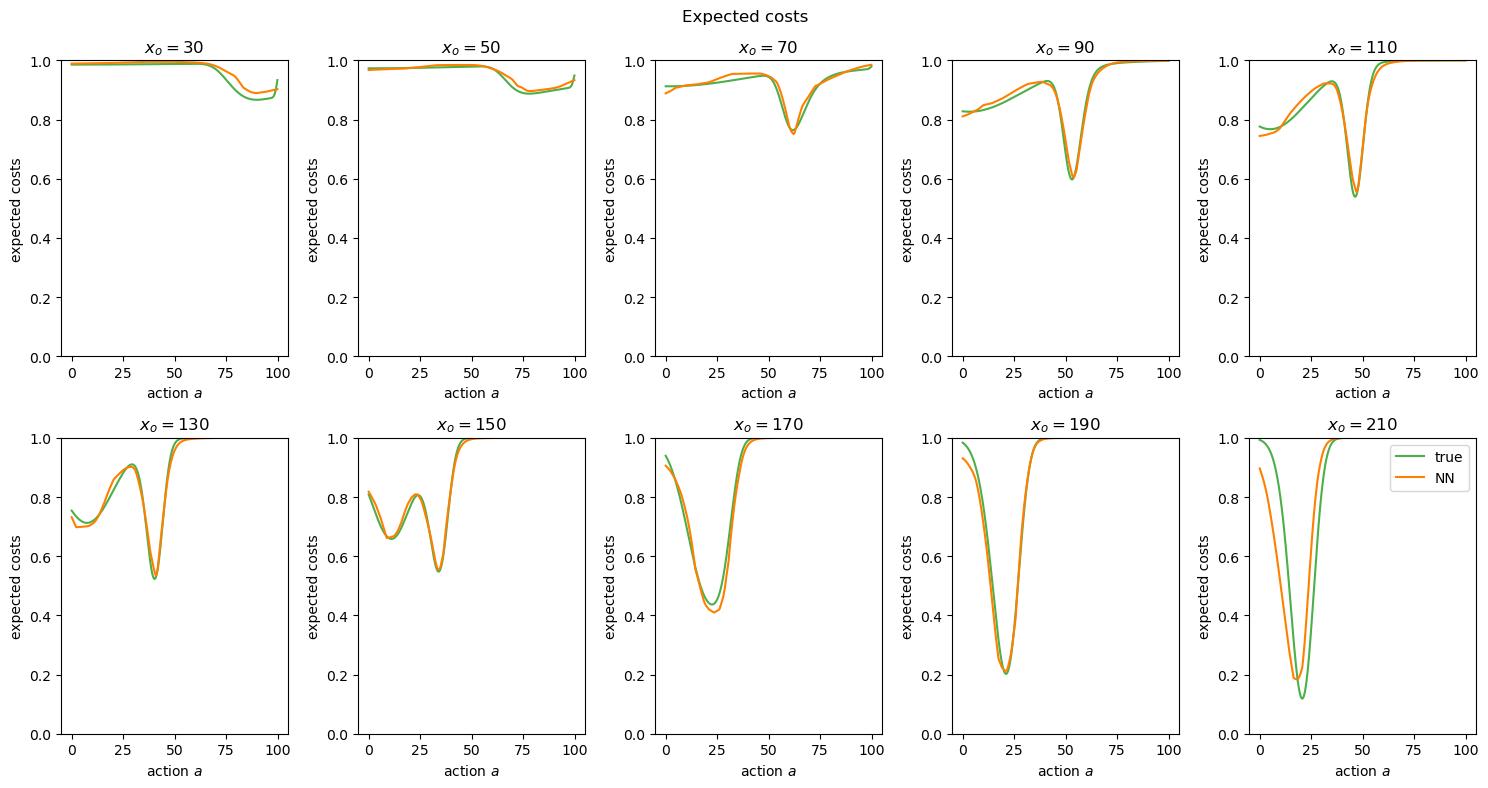

In [17]:
obs = torch.arange(30, 230, 20)
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

plt.figure(figsize=(15, 8))
for i, x in enumerate(obs):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = toy.expected_posterior_costs(
                x=x,
                a=a_grid,
                # lower=toy.param_low.item(),
                # upper=toy.param_high.item(),
                # resolution=resolution,
                cost_fn=cost_fn
            )

    predicted_costs = torch.tensor([nn(x,a) for a in a_grid])

    plt.plot(a_grid, expected_posterior_costs.squeeze(), c=color_post, label="true")
    plt.plot(a_grid, predicted_costs, c=color_nn, label="NN")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.ylim(0, 1)
    plt.title(rf"$x_o=${x}")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
# plt.savefig("./results/continuous/toy_example/fig_expected_costs.pdf")
plt.show()

### Further analysis

Resulting divergence in the chosen action

In [30]:
obs_grid = torch.arange(0, 220, 5)
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

expected_posterior_losses = [
    torch.tensor(
            toy.expected_posterior_costs(
                x=x_o,
                a=a_grid,
                cost_fn=cost_fn
            )
    )
    for x_o in obs_grid
]
expected_posterior_losses = torch.vstack(expected_posterior_losses)
predicted_losses = [torch.tensor([nn(x_o.reshape(-1, 1), a.reshape(-1, 1)) for a in a_grid]) for x_o in obs_grid]
predicted_losses = torch.stack(predicted_losses, dim=0)


a_gt = a_grid[expected_posterior_losses.argmin(dim=1)]
a_predicted = a_grid[predicted_losses.argmin(dim=1)]

(a_gt - a_predicted).abs().mean()

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_10816/169522329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


tensor(1.7568)

Resulting divergence in the incurred costs

In [31]:
torch.tensor(
    [
        (toy.expected_posterior_costs(x_o, a_true, cost_fn=cost_fn) - toy.expected_posterior_costs(x_o, a_pred, cost_fn=cost_fn)).abs()
        for x_o, a_true, a_pred in zip(obs_grid, a_gt, a_predicted)
    ]
).mean()

tensor(0.0165)

### Find the optimal action

Use gradient descent on the reverse expected costs (rescaled by the maximum) to find the optimal action

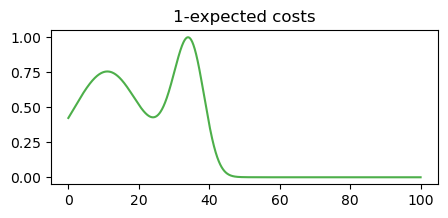

In [32]:
obs = torch.tensor([150.0])
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

plt.figure(figsize=(5, 2))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
plt.title("1-expected costs")
plt.plot(a_grid, reverse_costs / reverse_costs.max(), c=color_post, label="true")
plt.show()

In [33]:
from loss_cal.utils.analysis import expected_costs_wrapper

In [34]:
def reverse_costs(x: torch.Tensor, a: torch.Tensor, dist: str,cost_fn, nn=None) -> torch.Tensor:
    return 1 - expected_costs_wrapper(x, a, toy, dist, param=0, nn=nn, cost_fn=cost_fn)


reverse_costs_given_x_nn = partial(reverse_costs, obs, dist="nn", nn=nn, cost_fn=cost_fn)
reverse_costs_given_x_post = partial(reverse_costs, obs, dist="posterior", nn=None, cost_fn=cost_fn)

In [35]:
initial_actions = actions.sample(1000)
gd_best_action_nn, gd_costs_nn = gradient_ascent(
    potential_fn=reverse_costs_given_x_nn, inits=initial_actions, theta_transform=None
)
gd_best_action_nn, gd_costs_nn

(tensor([33.8017]), tensor([0.4451]))

In [36]:
gd_best_action_post, gd_costs_post = gradient_ascent(
    potential_fn=reverse_costs_given_x_post, inits=initial_actions, theta_transform=None
)
gd_best_action_post, gd_costs_post

(tensor([33.9622]), tensor([0.4521]))

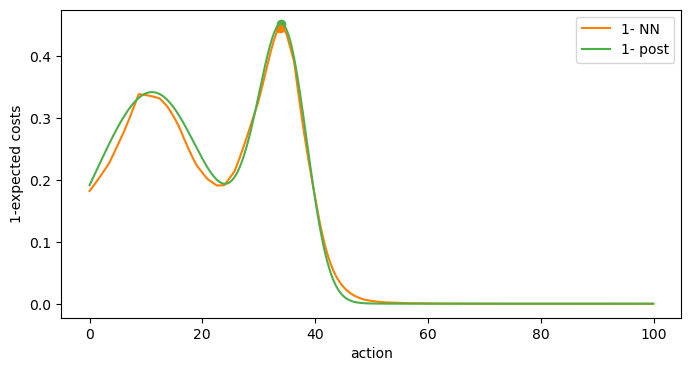

In [37]:
plt.figure(figsize=(8, 4))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
# plt.plot(a_grid, reverse_costs/reverse_costs.max(), label="true")
plt.scatter(gd_best_action_post, gd_costs_post, c=color_post)
plt.scatter(gd_best_action_nn, gd_costs_nn, c=color_nn)

plt.plot(a_grid, 1 - predicted_losses, label="1- NN", c=color_nn)
plt.plot(a_grid, reverse_costs, label="1- post", c=color_post)
plt.xlabel("action")
plt.ylabel("1-expected costs")
plt.legend()
# plt.plot(a_grid, predicted_losses, label="NN")
plt.show()

Test Code

In [38]:
from loss_cal.utils.analysis import find_optimal_action

In [40]:
post_action, _, post_costs = find_optimal_action(obs, task=toy, method='posterior', cost_fn=cost_fn, param=0, verbose=False)
post_action, 1-post_costs

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/toy_example.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean).to(self.device),


(tensor([33.9642]), tensor([0.4521]))

In [41]:
nn_action, nn_estimated_costs, nn_costs = find_optimal_action(obs, task=toy, method='nn', nn=nn, cost_fn=cost_fn, param=0, verbose=False)
nn_action, 1-nn_estimated_costs, 1-nn_costs

(tensor([33.8017]), tensor([0.4451]), tensor([0.4518]))

In [42]:
npe_action, npe_estimated_costs, npe_true_costs =torch.stack([torch.concat(find_optimal_action(obs, task=toy, method='nn', nn=nn, cost_fn=cost_fn, param=0, verbose=False)) for i in range(2)], dim=1)

In [43]:
npe_action

tensor([33.8017, 33.8017])

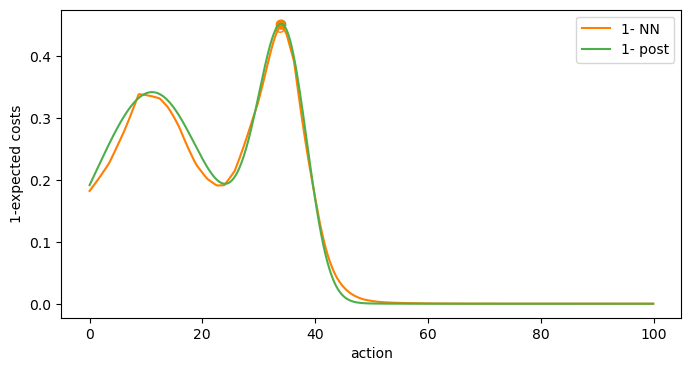

In [44]:
plt.figure(figsize=(8, 4))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
plt.scatter(post_action, 1-post_costs, c=color_post)
plt.scatter(nn_action, 1-nn_costs, c=color_nn)
plt.scatter(nn_action, 1-nn_estimated_costs, marker='o', facecolors='none', edgecolors=color_nn)

plt.plot(a_grid, 1 - predicted_losses, label="1- NN", c=color_nn)
plt.plot(a_grid, reverse_costs, label="1- post", c=color_post)
plt.xlabel("action")
plt.ylabel("1-expected costs")
plt.legend()
plt.show()